# MRF Estimation.  

**This notebook is the first implementation of a segmented MRFs **




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [169]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change these paths to point at your data and stimulus directories
path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
dataDir = '/Users/frederictheunissen/Documents/Classes/Summer Course - Boot Camp/2016/theunissen_tutorials/data'
stimsDir = os.path.join(dataDir, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [4]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(dataDir, cellDirName, 'conspecific')


In [5]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [6]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [7]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

In [8]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


### Generate the stimulus and response feature
The stimulus features are the MPS obtained for each song segment.  The song segments are obtained using a hard threshold and then merging short silences and short sounds.
The response feature is the PSTH smoothed with a hanning window.

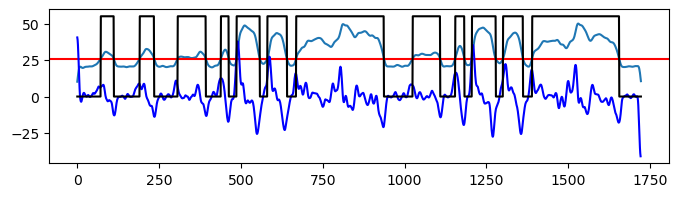

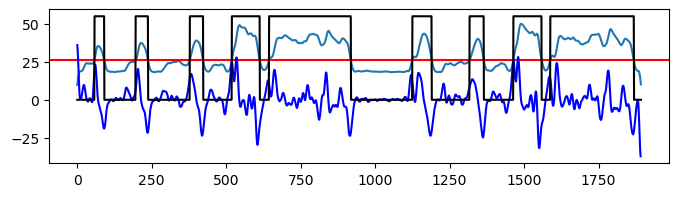

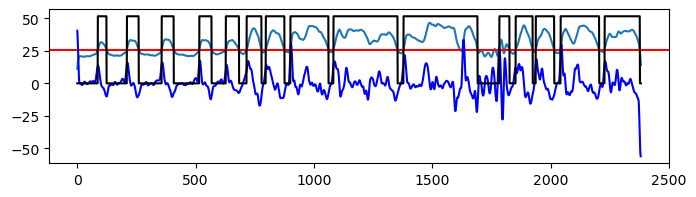

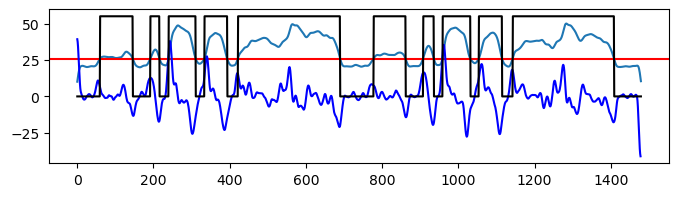

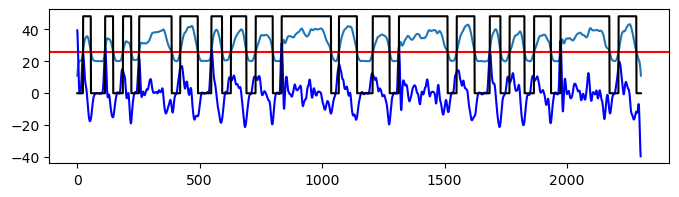

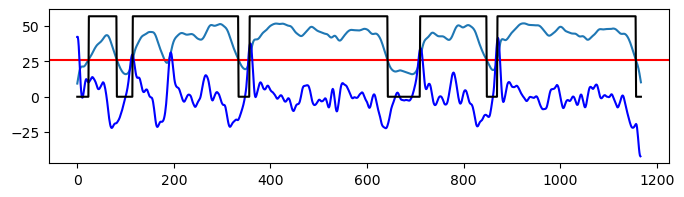

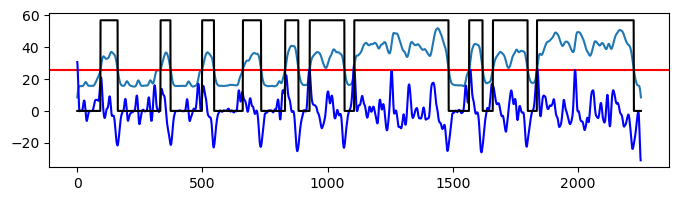

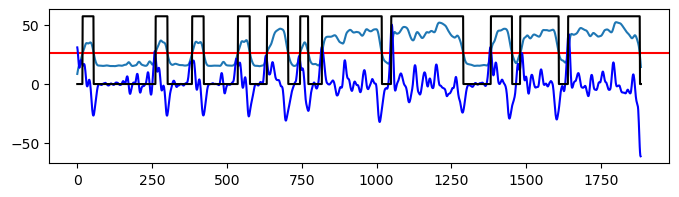

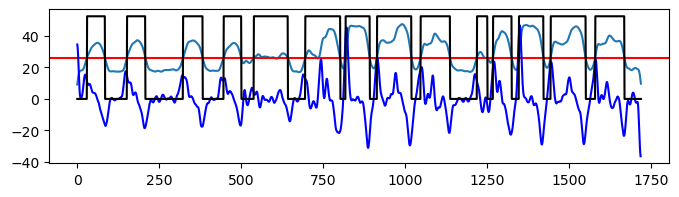

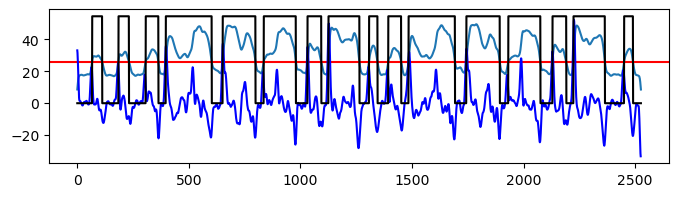

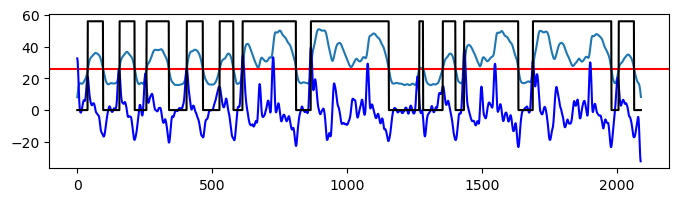

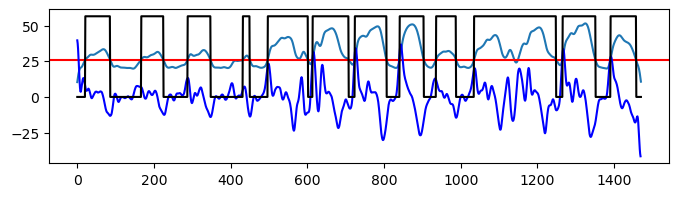

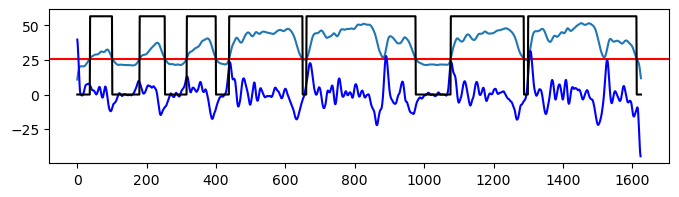

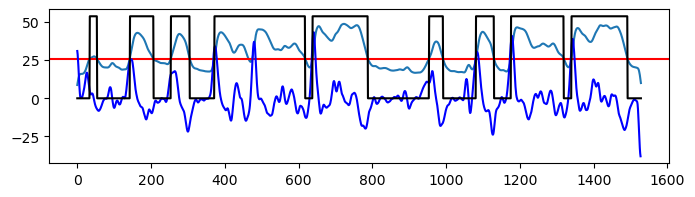

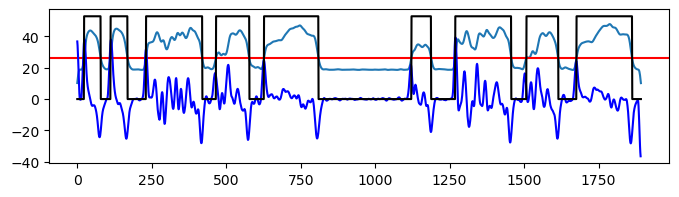

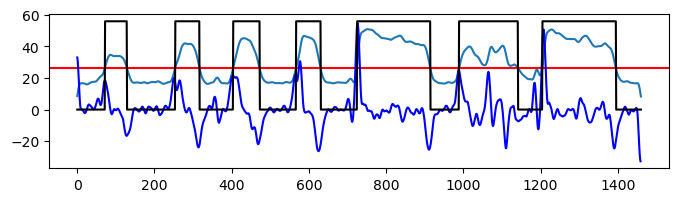

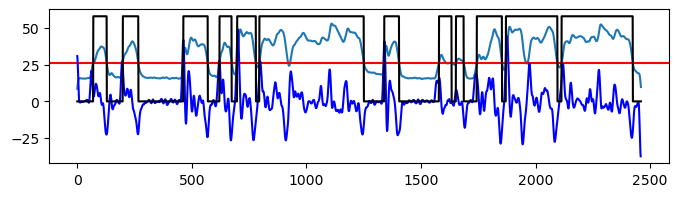

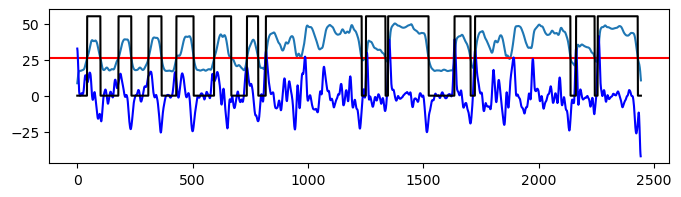

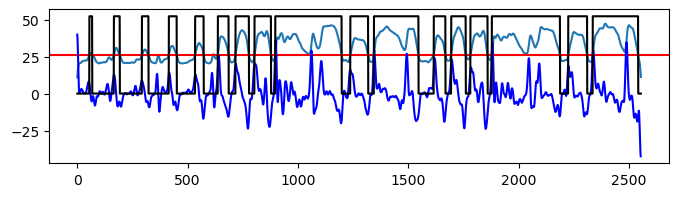

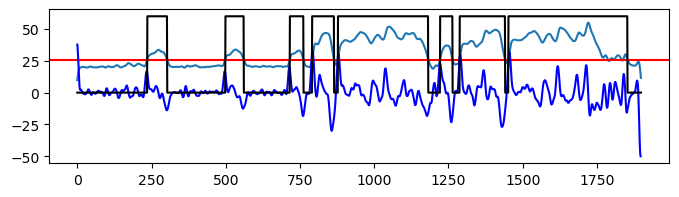

In [166]:
# Segmentation based on thresholding the enveloppe

ampThresh = 26.0  # Threshold in dB (max appears to be around  50 for the smoothed amplitude)
minSilence = 10  # Minimum length of silence in points - time units given by stim sample rate
minSound = 10  # Minimum length of sound in points
segmentBuffer = 25 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 200 # Response length in number of points 
DBNOISE = 60  # Set a baseline for everything below 70 dB from max


wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH
wHann = wHann/sum(wHann)

stimMPS = []
stimSpect = []
respMPS = []
chunkID = {'set': [], 'indZero': [], 'indStart' : [], 'indEnd' : [], 'respIndStart' : [], 'respIndEnd' : []}



for iSet in range(pairCount) :

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    spectro = np.copy(srData['datasets'][iSet]['stim']['tfrep']['spec'])
    dBMax = spectro.max()
    spectro[spectro < dBMax-DBNOISE] = dBMax-DBNOISE

    ampenv = np.mean(spectro, axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']

    nSound = int((respChunkLen)*fs/ampfs)   # number of time points in sound chunks - should be the same for all stimulus-response pairs

    ampenv = np.convolve(ampenv, wHann, mode='same')


    plt.figure(figsize=(8,2), dpi=100)
    plt.plot(ampenv)
    plt.axhline(ampThresh, color = 'r')
    ampdev = ampenv[1:]-ampenv[0:-1]
    plt.plot(20*ampdev, color = 'b')

    # Make a threshold
    soundOn = np.ones(ampenv.shape)
    soundOn[ampenv < ampThresh] = 0

    # Find edges and remove silences below 10 ms
    edges = soundOn[1:]-soundOn[0:-1]
    silBeg = np.argwhere(edges == -1)+1
    silEnd = np.argwhere(edges == 1)

    for silStart in silBeg:
        silFinish = np.argwhere(silEnd >= silStart)
        if silFinish.shape[0]:
            dt = silEnd[silFinish[0][0]]-silStart
            # print (silStart, silEnd[silFinish[0][0]], dt)   
            if dt < minSilence:
                # print(int(silStart), int(silEnd[silFinish[0][0]]+1))
                soundOn[int(silStart):int(silEnd[silFinish[0][0]]+1)] = 1.0

    # Remove sounds shorter than 10 ms
    edges = soundOn[1:]-soundOn[0:-1]
    soundEnd = np.argwhere(edges == -1)
    soundBeg = np.argwhere(edges == 1)+1

    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:
            dt = soundEnd[soundFinish[0][0]]-soundStart
            # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
            if dt < minSound:
                # print(int(soundStart), int(soundEnd[soundFinish[0][0]]+1))
                soundOn[int(soundStart):int(soundEnd[soundFinish[0][0]]+1)] = 0

    
    # Recalculate Edges
    edges = soundOn[1:]-soundOn[0:-1]
    soundEnd = np.argwhere(edges == -1)
    soundBeg = np.argwhere(edges == 1)+1

    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:
            dt = soundEnd[soundFinish[0][0]]-soundStart
            # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
            if dt < minSound:
                print('WARNING - not expecting short sound here', int(soundStart), int(soundEnd[soundFinish[0][0]]+1))


    plt.plot(soundOn*(np.max(ampenv)+5), 'k')

    # Plot response
    resp = srData['datasets'][iSet]['resp']['psth']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    respDataLen = respSmoothed.shape[0]

    # plt.plot(respSmoothed*np.max(ampenv)/np.max(respSmoothed), 'r')
    if iSet == 2:
        plt.savefig(os.path.join(figDir, 'song_segment.eps'))

    # Extract the MPS for each event and use 25 ms buffer to account for latency
    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:

            # First estimate MPS for chunk
            wavSound = np.zeros(nSound)
            indStart = int((soundStart-segmentBuffer)*fs/ampfs)
            if indStart < 0 :
                indCopyStart = -indStart
                indStart = 0
            else:
                indCopyStart = 0

            # indEnd = int((soundEnd[soundFinish[0][0]]+segmentBuffer)*fs/ampfs)
            indEnd = int((soundStart+respChunkLen-segmentBuffer)*fs/ampfs)
            if indEnd > soundLen:
                indCopyEnd = nSound - (indEnd-soundLen)
                indEnd = soundLen
            else:
                indCopyEnd = nSound

            if ((indEnd-indStart) != (indCopyEnd-indCopyStart)) :
                print('Missmatch in song copying: indStart = %d indEnd = %d len = %d '%(indStart, indEnd, indEnd-indStart) )
                print('\t indCopyStart = %d indCopyEnd = %d len = %d '%(indCopyStart, indCopyEnd, indCopyEnd-indCopyStart) )
                print('\t Sound len = %d '%(nSound) )
                break


            wavSound[indCopyStart:indCopyEnd] = soundStim[indStart:indEnd]

            # Create BioSound Object and calculate basic sound features
            myBioSound = BioSound(soundWave=wavSound, fs=fs, emitter='STRF', calltype = 'song')
            myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=500, max_freq=8000)
            myBioSound.rms = myBioSound.sound.std() 
            myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
            myBioSound.spectrum(f_high=10000)
            myBioSound.mpsCalc(window=0.05, Norm = True)  # Norm equals true normalizes the spectrogram but not the MPS
        
            # Store in list
            stimMPS.append(myBioSound.mps)
            stimSpect.append(myBioSound.spectro)

            # Now extract response for the same chunk.
            respChunk = np.zeros(respChunkLen)
            indZero = int(soundStart)
 
            indEnd = int((soundEnd[soundFinish[0][0]]+segmentBuffer))
            if indEnd > respDataLen:
                indEnd = respDataLen
            respIndEnd = segmentBuffer + (indEnd-indZero)
            if respIndEnd > respChunkLen:
                respIndEnd = respChunkLen
                indEnd = indZero + (respIndEnd-segmentBuffer)

            respChunk[segmentBuffer:respIndEnd] = respSmoothed[indZero:indEnd]

            respIndStart = 0
            indStart = indZero - segmentBuffer
            if indStart < 0:
                indStart = 0
                respIndStart = segmentBuffer - indZero

            respChunk[respIndStart:segmentBuffer] = respSmoothed[indStart:indZero]

            respMPS.append(respChunk)
            chunkID['set'].append(iSet)
            chunkID['indStart'].append(indStart)
            chunkID['indZero'].append(indZero)
            chunkID['indEnd'].append(indEnd)
            chunkID['respIndStart'].append(respIndStart)
            chunkID['respIndEnd'].append(respIndEnd)




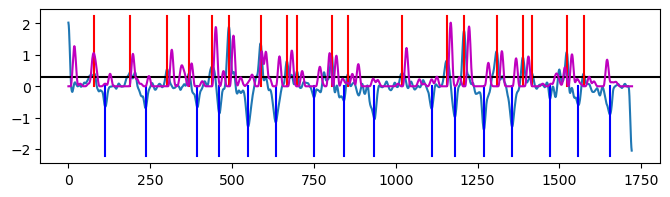

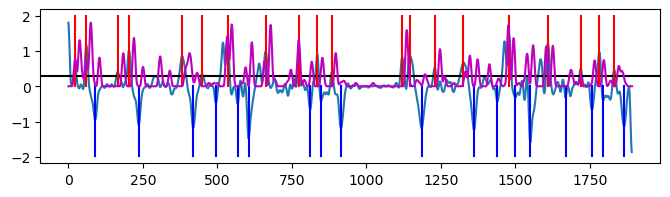

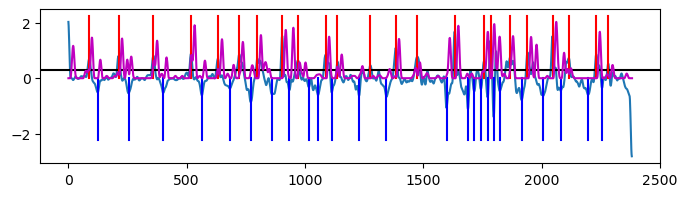

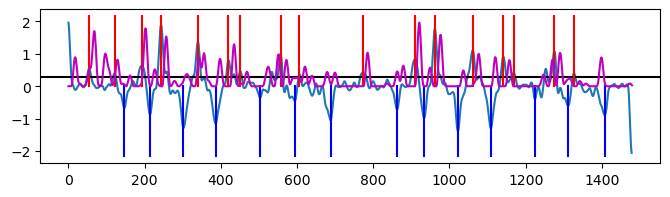

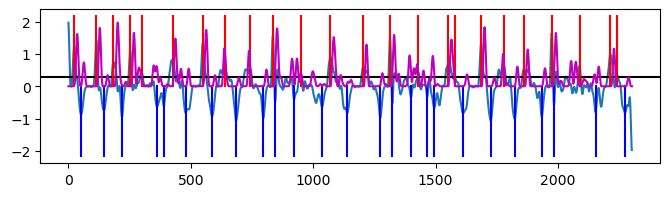

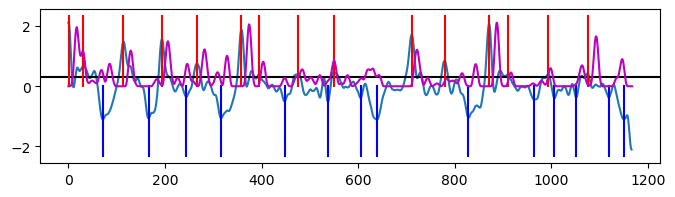

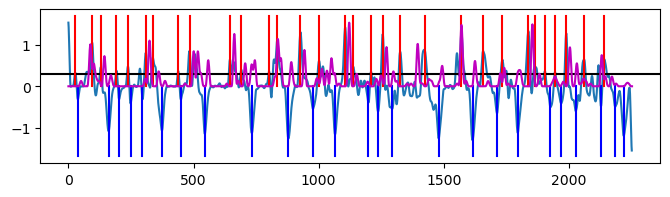

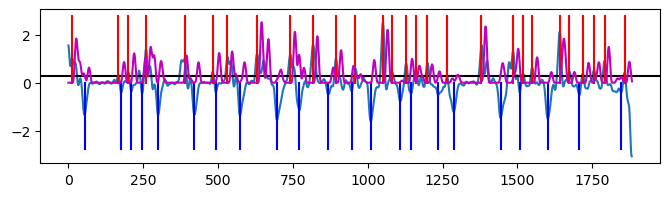

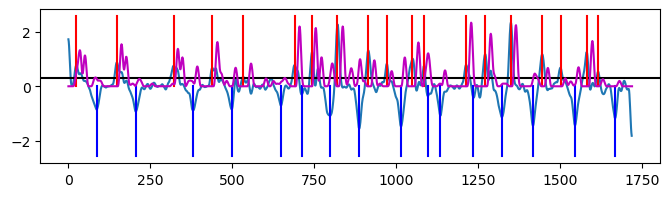

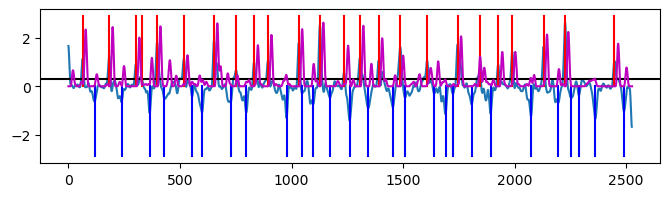

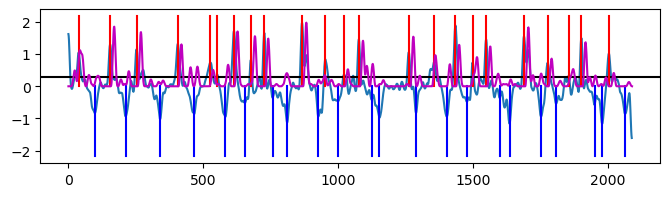

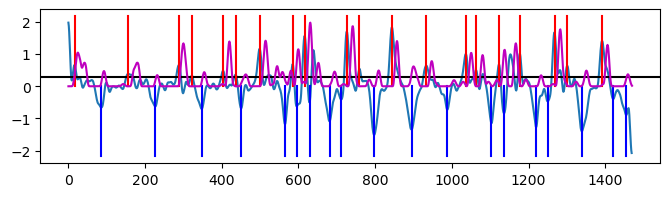

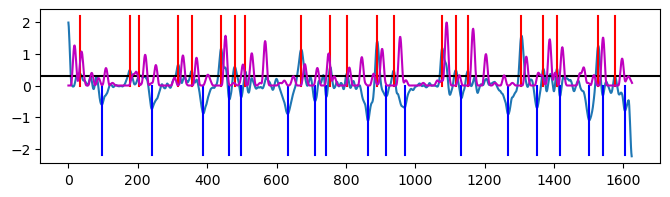

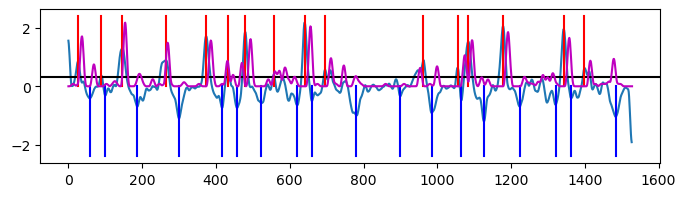

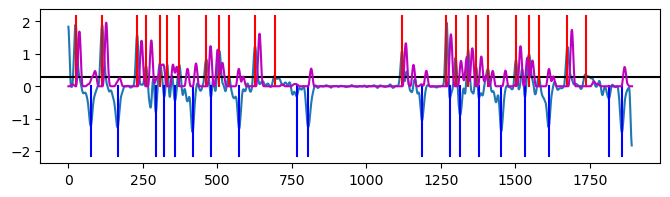

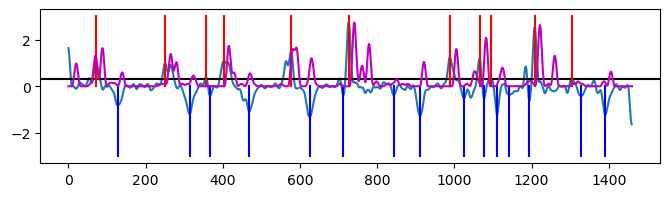

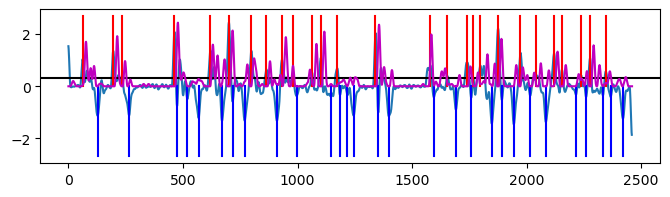

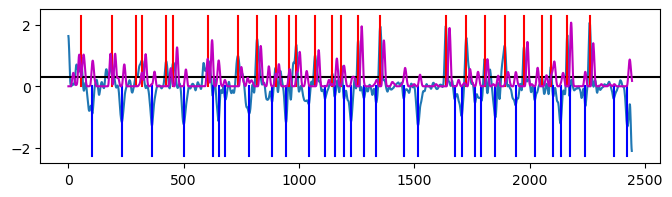

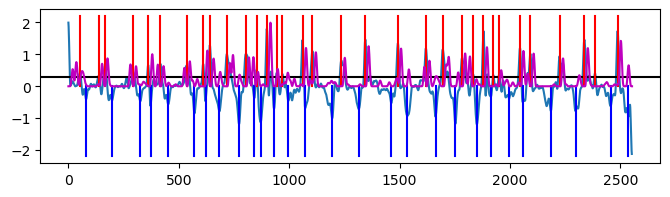

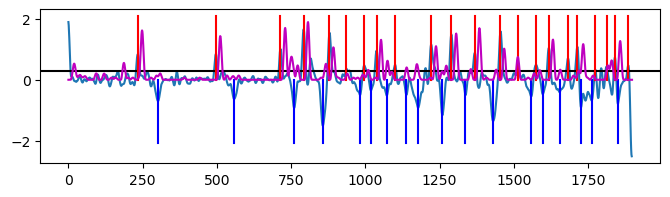

In [244]:
# Segmentation based on derivative of the enveloppe

ampThresh = 20.0  # Threshold in dB where 50 is max

minSound = 25  # Minimum distance between peaks or troffs
derivativeThresh = 0.3  # Thresnold derivative 0.5 dB per ms.
segmentBuffer = 25 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 200 # Total chunk length (including segment buffer) in number of points 
DBNOISE = 60  # Set a baseline for everything below 70 dB from max


wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH
wHann = wHann/sum(wHann)

stimMPS = []
stimSpect = []
respMPS = []
chunkID = {'set': [], 'indZero': [], 'indStart' : [], 'indEnd' : [], 'respIndStart' : [], 'respIndEnd' : []}



for iSet in range(pairCount) :

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    spectro = np.copy(srData['datasets'][iSet]['stim']['tfrep']['spec'])
    dBMax = spectro.max()
    spectro[spectro < dBMax-DBNOISE] = dBMax-DBNOISE

    ampenv = np.mean(spectro, axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']

    nSound = int((respChunkLen)*fs/ampfs)   # number of time points in sound chunks - should be the same for all stimulus-response pairs

    ampenv = np.convolve(ampenv, wHann, mode='same')
    ampdev = ampenv[1:]-ampenv[0:-1]
    
    # Find peaks and troughs
    peakInd, peakVals = find_peaks(ampdev, height = derivativeThresh, distance=minSound)
    troughInd, troughVals = find_peaks(-ampdev, height= derivativeThresh, distance=minSound)

    plt.figure(figsize=(8,2), dpi=100)
    plt.plot(ampdev)
    plt.axhline(derivativeThresh, color = 'k')

    for soundStart in peakInd:
        soundFinish = np.argwhere(troughInd >= soundStart + minSound)
        if soundFinish.shape[0]:
            dt = troughInd[soundFinish[0][0]]-soundStart
            # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
            if dt < minSound:
                print('WARNING - not expecting short sound here', int(soundStart), int(troughInd[soundFinish[0][0]]+1))

    for soundStart in peakInd:
        plt.plot([soundStart, soundStart], [0, np.max(ampdev)*1.1], 'r')

    for soundEnd in troughInd:
        plt.plot([soundEnd, soundEnd], [0, -np.max(ampdev)*1.1], 'b')


    # Plot response
    resp = srData['datasets'][iSet]['resp']['psth']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    respDataLen = respSmoothed.shape[0]

    plt.plot(respSmoothed*np.max(ampdev)/np.max(respSmoothed), 'm')
    
    # Saving figure
    if iSet == -1:
        plt.savefig(os.path.join(figDir, 'song_segment.eps'))

    # Extract the MPS for each event and use a buffer to account for latency
    for ipk, soundStart in enumerate(peakInd):
        soundEnd1 = troughInd[troughInd >= soundStart+ minSound]
        if ipk < len(peakInd)-1:
            soundEnd2 = peakInd[ipk+1]
        else:
            soundEnd2 = []
        
        if soundEnd1.shape[0]:
            
            if soundEnd2 != []:
                soundEnd = min(soundEnd1[0], soundEnd2)
            else:
                soundEnd = soundEnd1[0]
        else:
            if soundEnd2 != []:
                soundEnd = soundEnd2
            else:
                soundEnd = soundStart + respChunkLen - segmentBuffer


        # First estimate MPS for chunk
        wavSound = np.zeros(nSound)
        indStart = int((soundStart-segmentBuffer)*fs/ampfs)
        if indStart < 0 :
            indCopyStart = -indStart
            indStart = 0
        else:
            indCopyStart = 0

        # indEnd = int((soundEnd[soundFinish[0][0]]+segmentBuffer)*fs/ampfs)
        indEnd = int(soundEnd*fs/ampfs)
        if indEnd > soundLen:
            indEnd = soundLen
        if (indEnd-indStart > nSound) :
            indEnd = indStart + nSound

        indCopyEnd = indEnd-indStart+indCopyStart

        # This should not be possible but left here for check for now.
        if ((indEnd-indStart) != (indCopyEnd-indCopyStart)) :
            print('Missmatch in song copying: indStart = %d indEnd = %d len = %d '%(indStart, indEnd, indEnd-indStart) )
            print('\t indCopyStart = %d indCopyEnd = %d len = %d '%(indCopyStart, indCopyEnd, indCopyEnd-indCopyStart) )
            print('\t Sound len = %d '%(nSound) )
            break


        wavSound[indCopyStart:indCopyEnd] = soundStim[indStart:indEnd]

        # Create BioSound Object and calculate basic sound features
        myBioSound = BioSound(soundWave=wavSound, fs=fs, emitter='STRF', calltype = 'song')
        myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=500, max_freq=8000)
        myBioSound.rms = myBioSound.sound.std() 
        myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
        myBioSound.spectrum(f_high=10000)
        myBioSound.mpsCalc(window=0.05, Norm = True)  # Norm equals true normalizes the spectrogram but not the MPS
        
        # Store in list
        stimMPS.append(myBioSound.mps)
        stimSpect.append(myBioSound.spectro)

        # Now extract response for the same chunk.
        respChunk = np.zeros(respChunkLen)
        indZero = int(soundStart)
 
        indEnd = soundEnd+segmentBuffer
        if indEnd > respDataLen:
            indEnd = respDataLen

        respIndEnd = segmentBuffer + (indEnd-indZero)
        if respIndEnd > respChunkLen:
            respIndEnd = respChunkLen
            indEnd = indZero + (respIndEnd-segmentBuffer)

        respChunk[segmentBuffer:respIndEnd] = respSmoothed[indZero:indEnd]

        respIndStart = 0
        indStart = indZero - segmentBuffer
        if indStart < 0:
            indStart = 0
            respIndStart = segmentBuffer - indZero

        respChunk[respIndStart:segmentBuffer] = respSmoothed[indStart:indZero]

        respMPS.append(respChunk)
        chunkID['set'].append(iSet)
        chunkID['indStart'].append(indStart)
        chunkID['indZero'].append(indZero)
        chunkID['indEnd'].append(indEnd)
        chunkID['respIndStart'].append(respIndStart)
        chunkID['respIndEnd'].append(respIndEnd)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.2940807  0.10468027 0.09074389 0.079601   0.07036351 0.05923458
 0.04989711 0.04222085 0.03412187 0.0311319 ]


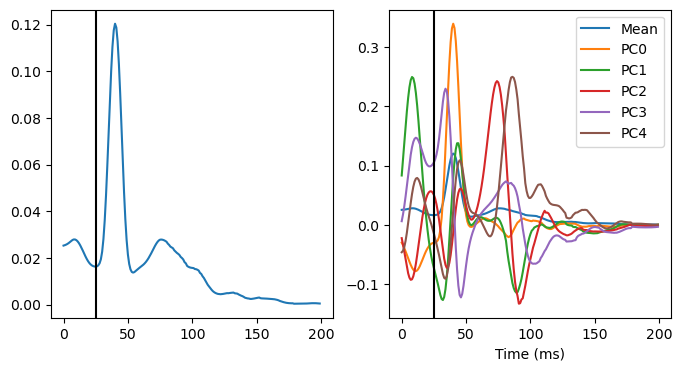

In [245]:
# Plot the mean responsem and the PCs

# Mean Response
respMPS = np.array(respMPS)
plt.figure(figsize = (8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(respMPS.mean(axis=0))
plt.axvline(segmentBuffer, color = 'k')

# Calculate the PCs
pcResp = PCA(n_components=10)
respPC = pcResp.fit_transform(respMPS)
print(pcResp.explained_variance_ratio_)

# Plot the PCs
plt.subplot(1,2,2)
plt.plot(pcResp.mean_, label='Mean')
for iPC in range(5):
    plt.plot(pcResp.components_[iPC,:], label='PC%d'%(iPC))
plt.axvline(segmentBuffer, color = 'k')
plt.xlabel('Time (ms)')
plt.legend()

plt.savefig(os.path.join(figDir, 'RespPCs.eps'))


In [246]:
def normLaguerre(xt, amp, alpha, tau):
    return amp*np.exp(-xt/tau)*np.power(xt/tau, alpha)

(0.0, 250.0, -0.5, 0.5)

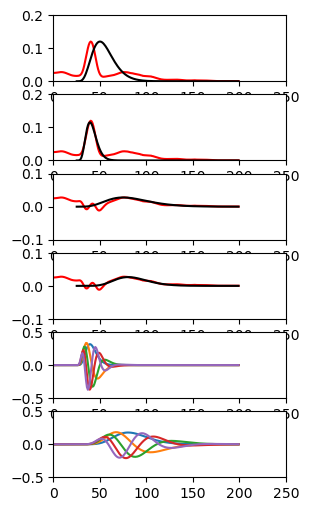

In [247]:
# Find optimal Laguerre expansion for onset and sustained componnents
meanResp = respMPS.mean(axis=0)

p0 = np.array([1, 5, 5])
xt = np.linspace(0, respMPS.shape[1] - segmentBuffer, num = respMPS.shape[1] - segmentBuffer, endpoint=False )  # time vector in ms
yval = normLaguerre(xt, *p0)

amp = max(meanResp)/max(yval)

plt.figure(figsize = (3,6), dpi=100)
plt.subplot(6,1,1)
plt.plot(meanResp, 'r')
plt.plot(xt+segmentBuffer, amp*yval, color = 'k')
plt.axis([0, 250, 0, 0.2])

popt, pcov = curve_fit(normLaguerre, xt, meanResp[segmentBuffer:], p0=np.array([amp, 5, 5]))
yval = normLaguerre(xt, *popt)
plt.subplot(6,1,2)
plt.plot(meanResp, 'r')
plt.plot(xt+segmentBuffer, yval, color = 'k')
plt.axis([0, 250, 0, 0.2])

adjResp = np.copy(meanResp)
adjResp[segmentBuffer:] = adjResp[segmentBuffer:] - yval
p0 = np.array([1, 5, 10])
yval2 = normLaguerre(xt, *p0)
amp = max(adjResp)/max(yval2)
plt.subplot(6,1,3)
plt.plot(adjResp, 'r')
plt.plot(xt+segmentBuffer, amp*yval2, color = 'k')
plt.axis([0, 250, -0.1, 0.1])

popt2, pcov2 = curve_fit(normLaguerre, xt, adjResp[segmentBuffer:], p0=np.array([amp, 5, 5]))
yval2 = normLaguerre(xt, *popt2)
plt.subplot(6,1,4)
plt.plot(adjResp, 'r')
plt.plot(xt+segmentBuffer, yval2, color = 'k')
plt.axis([0, 250, -0.1, 0.1])

plt.subplot(6,1,5)
order = 5
onsetLG = np.zeros((order, respMPS.shape[1]))
for xorder in np.arange(0, order):
    y = np.exp(-xt/popt[2])*np.power(xt/popt[2], popt[1])*genlaguerre(xorder, popt[1])(xt/popt[2])
    y2 = np.exp(-xt/popt[2])*np.power(xt/popt[2], popt[1])*(genlaguerre(xorder, popt[1])(xt/popt[2]))**2
    ynorm = np.sqrt(np.sum(y**2))
    onsetLG[xorder, segmentBuffer:] = y/ynorm
    plt.plot( onsetLG[xorder], label=f'{xorder}')

plt.axis([0, 250, -0.5, 0.5])

plt.subplot(6,1,6)
order = 5
sustainedLG = np.zeros((order, respMPS.shape[1]))
for xorder in np.arange(0, order):
    y = np.exp(-xt/popt2[2])*np.power(xt/popt2[2], popt2[1])*genlaguerre(xorder, popt2[1])(xt/popt2[2])
    y2 = np.exp(-xt/popt2[2])*np.power(xt/popt2[2], popt2[1])*(genlaguerre(xorder, popt2[1])(xt/popt2[2]))**2
    ynorm = np.sqrt(np.sum(y**2))
    sustainedLG[xorder, segmentBuffer:] = y/ynorm
    plt.plot(sustainedLG[xorder], label=f'{xorder}')

plt.axis([0, 250, -0.5, 0.5])



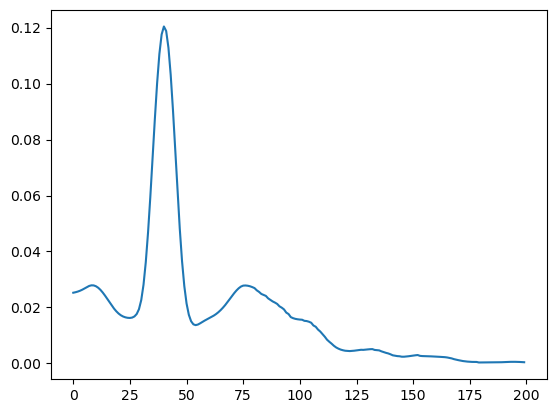

In [248]:
plt.figure()
plt.plot(meanResp)

In [249]:
# Find the response coefficients for the Laguerre expansion
nResps = respPC.shape[0]
respLG = np.zeros((nResps, order*2))

for iSegment in range(nResps):
        
    yresp = respMPS[iSegment]-meanResp
   
   # Onset coefficients
    yOnset = np.zeros(yresp.shape)
    for io in range(order):
        respLG[iSegment, io] = np.dot(onsetLG[io],yresp)
        yresp -= respLG[iSegment, io]*onsetLG[io]
        # yOnset += respLG[iSegment, io]*onsetLG[io]

    
    # Sustained coefficients
    for io in range(order):
        respLG[iSegment, io+order] = np.dot(sustainedLG[io],yresp)
        yresp -= respLG[iSegment, io+order]*sustainedLG[io]

        


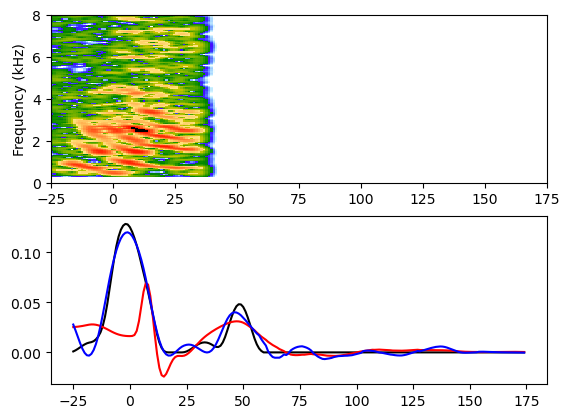

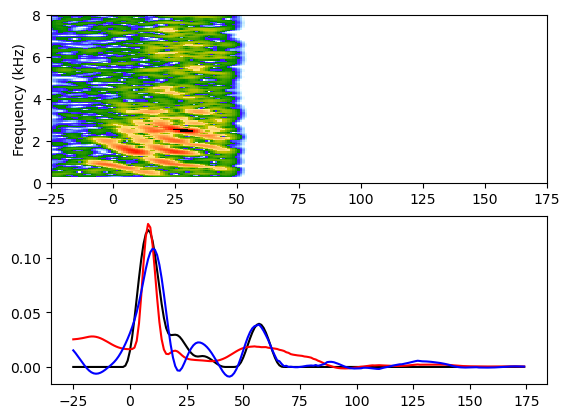

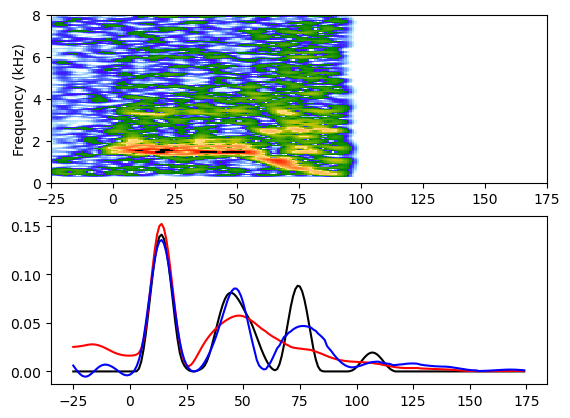

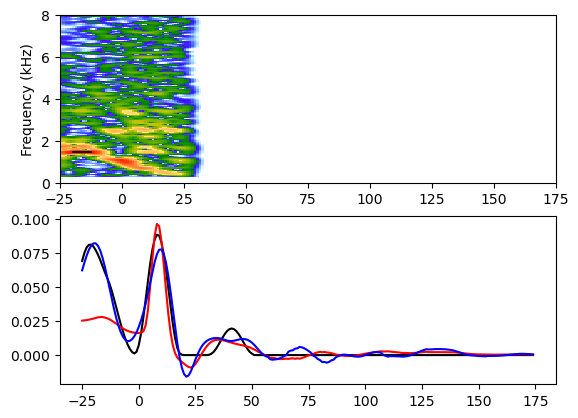

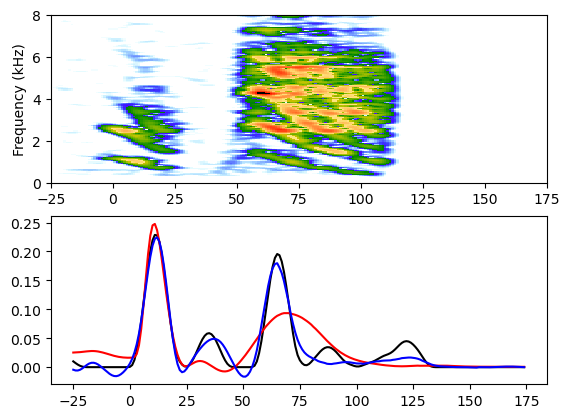

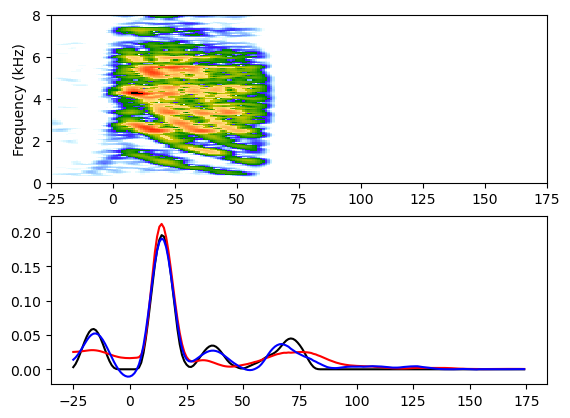

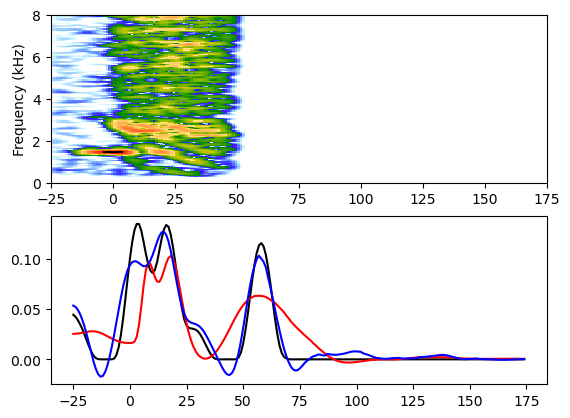

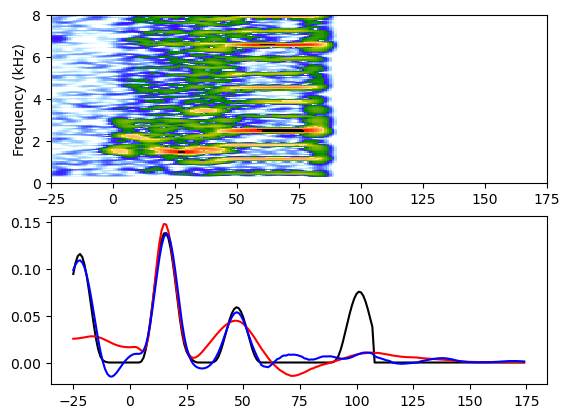

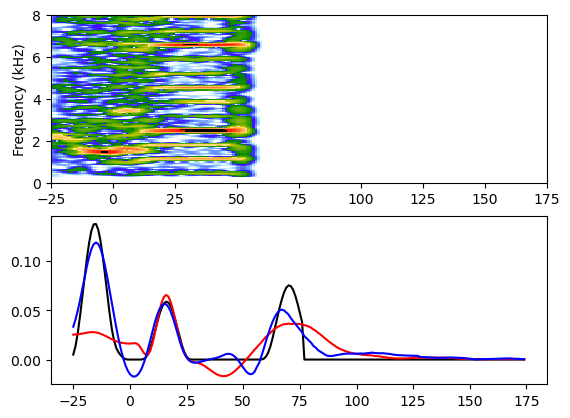

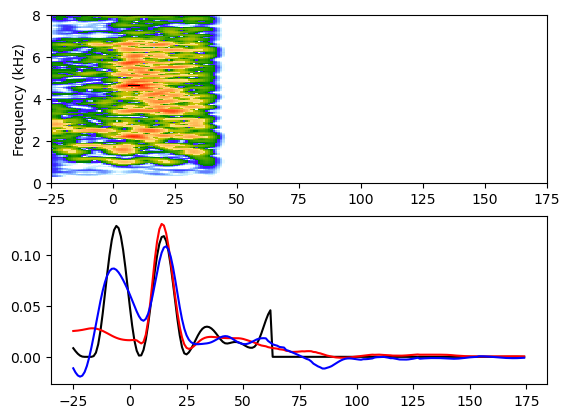

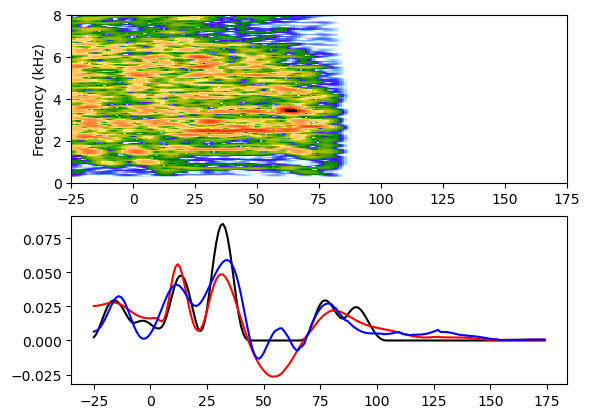

In [250]:
# Check reconstruction
DBNOISE = 50
for iSegment in range(nResps):

    yresp = np.copy(meanResp)
    yPC = np.copy(meanResp)
    for io in range(order):
        yresp += respLG[iSegment, io]*onsetLG[io]
    for io in range(order):
        yresp += respLG[iSegment, io+order]*sustainedLG[io]

    for iPC in range(10):
        yPC += pcResp.components_[iPC]*respPC[iSegment, iPC]

    plt.figure()
    ax1 = plt.subplot(2,1,1)
    soundSpect = np.copy(stimSpect[iSegment])
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(soundSpect, extent=[-segmentBuffer, respChunkLen-segmentBuffer, 0.25, 8],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
  

    plt.subplot(2,1,2)
    t = np.linspace(start = - segmentBuffer, stop = respChunkLen-segmentBuffer, num=len(yresp), endpoint = False)
    plt.plot(t, respMPS[iSegment], 'k')
    plt.plot(t, yresp, 'r')
    plt.plot(t, yPC, 'b')

    if iSegment == 10:
        break
    


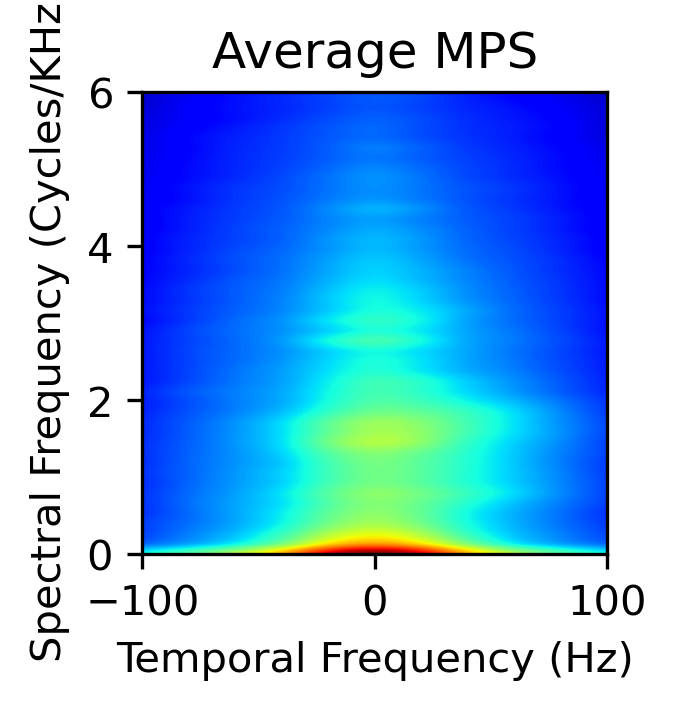

In [251]:
# Plot the average MPS.

wt = myBioSound.wt
wf = myBioSound.wf

stimMPS = np.array(stimMPS)
mpsAVG = stimMPS.mean(axis=0)

DBNOISE = 50
plt.figure(dpi=300, figsize=(2,2))
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
logMPS = 10.0*np.log10(mpsAVG)
maxMPS = logMPS.max()
minMPS = maxMPS-DBNOISE
logMPS[logMPS < minMPS] = minMPS
plt.imshow(logMPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')

plt.ylim((0,6))
plt.xlim((-100, 100))
plt.title('Average MPS')
plt.savefig(os.path.join(figDir, 'StimMPS.eps'))

set up strflab

In [252]:
# Use center of MPS for feature

# Find the indices of the center
indwt = np.argwhere((wt > -100) & (wt < 100))
indwf = np.argwhere( (wf >= 0) & (wf <6e-3))

stimMPSFeat = stimMPS[:,int(indwf[0]):int(indwf[-1]+1),int(indwt[0]):int(indwt[-1]+1)].reshape(stimMPS.shape[0], len(indwt)*len(indwf))

stimMPSFeat = stimMPSFeat - stimMPSFeat.mean(axis=0)

In [253]:
# Create the spectrogram features
stimSpect = np.array(stimSpect)
stimSpectFeat = stimSpect.reshape(stimSpect.shape[0], stimSpect.shape[1]*stimSpect.shape[2])

maxB = stimSpectFeat.max()
minB = maxB-DBNOISE
stimSpectFeat[stimSpectFeat < minB] = minB
stimSpectFeat = stimSpectFeat - stimSpectFeat.mean(axis=0)


In [254]:
# Perform cross-validated ridge regression for all PCs for MPS
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
nPC = respPC.shape[1]

# Allocate space for predictions
respPCPred = np.zeros(respPC.shape)
r2PC = np.zeros(nPC)
MRF = np.zeros((nPC, stimMPSFeat.shape[1]))


for iPC in range(nPC):
    clf = RidgeCV(alphas=Alphas)
    clf.fit(stimMPSFeat, respPC[:,iPC])
    respPCPred[:,iPC] = clf.predict(stimMPSFeat)
    r2PC[iPC] = clf.score(stimMPSFeat, respPC[:,iPC])
    MRF[iPC,:] = clf.coef_

    print('PC %d: Best alpha = %g R2 = %.3f' % (iPC, clf.alpha_, r2PC[iPC]))


PC 0: Best alpha = 100000 R2 = 0.376
PC 1: Best alpha = 1e+07 R2 = 0.075
PC 2: Best alpha = 100000 R2 = 0.306
PC 3: Best alpha = 100000 R2 = 0.248
PC 4: Best alpha = 1e+06 R2 = 0.168
PC 5: Best alpha = 1e+06 R2 = 0.154
PC 6: Best alpha = 100000 R2 = 0.207
PC 7: Best alpha = 1e+06 R2 = 0.183
PC 8: Best alpha = 1e+07 R2 = 0.057
PC 9: Best alpha = 1e+07 R2 = 0.035


In [255]:
# Repeat for spectrogram
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
nPC = respPC.shape[1]

# Allocate space for predictions
respPCPredSpect = np.zeros(respPC.shape)
r2PCSpect = np.zeros(nPC)
SRF = np.zeros((nPC, stimSpectFeat.shape[1]))


for iPC in range(nPC):
    clf = RidgeCV(alphas=Alphas)
    clf.fit(stimSpectFeat, respPC[:,iPC])
    respPCPredSpect[:,iPC] = clf.predict(stimSpectFeat)
    r2PCSpect[iPC] = clf.score(stimSpectFeat, respPC[:,iPC])
    SRF[iPC,:] = clf.coef_

    print('PC %d: Best alpha = %g R2 = %.3f' % (iPC, clf.alpha_, r2PCSpect[iPC]))

PC 0: Best alpha = 100000 R2 = 0.903
PC 1: Best alpha = 100000 R2 = 0.874
PC 2: Best alpha = 100000 R2 = 0.871
PC 3: Best alpha = 1e+06 R2 = 0.510
PC 4: Best alpha = 100000 R2 = 0.881
PC 5: Best alpha = 100000 R2 = 0.849
PC 6: Best alpha = 1e+06 R2 = 0.480
PC 7: Best alpha = 100000 R2 = 0.880
PC 8: Best alpha = 1e+06 R2 = 0.414
PC 9: Best alpha = 1e+06 R2 = 0.409


In [256]:
# Perform cross-validated ridge regression for all Laguerres
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
nLG = respLG.shape[1]

# Allocate space for predictions
respLGPred = np.zeros(respLG.shape)
r2LG = np.zeros(nLG)
MRF_LG = np.zeros((nLG, stimMPSFeat.shape[1]))


for iLG in range(nLG):
    clf = RidgeCV(alphas=Alphas)
    clf.fit(stimMPSFeat, respLG[:,iLG])
    respLGPred[:,iLG] = clf.predict(stimMPSFeat)
    r2LG[iLG] = clf.score(stimMPSFeat, respLG[:,iLG])
    MRF_LG[iLG,:] = clf.coef_

    print('LG %d: Best alpha = %g R2 = %.3f' % (iLG, clf.alpha_, r2LG[iLG]))

LG 0: Best alpha = 100000 R2 = 0.379
LG 1: Best alpha = 1e+06 R2 = 0.145
LG 2: Best alpha = 1e+06 R2 = 0.140
LG 3: Best alpha = 1e+06 R2 = 0.122
LG 4: Best alpha = 1e+07 R2 = 0.034
LG 5: Best alpha = 100000 R2 = 0.371
LG 6: Best alpha = 10000 R2 = 0.470
LG 7: Best alpha = 1e+07 R2 = 0.068
LG 8: Best alpha = 1e+06 R2 = 0.133
LG 9: Best alpha = 100000 R2 = 0.321


In [267]:
# Perform cross-validated ridge regression for all Laguerres for spectrogram
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
nLG = respLG.shape[1]

# Allocate space for predictions
respLGPredSpect = np.zeros(respLG.shape)
r2LGSpect = np.zeros(nLG)
SRF_LG = np.zeros((nLG, stimSpectFeat.shape[1]))


for iLG in range(nLG):
    clf = RidgeCV(alphas=Alphas)
    clf.fit(stimSpectFeat, respLG[:,iLG])
    respLGPredSpect[:,iLG] = clf.predict(stimSpectFeat)
    r2LGSpect[iLG] = clf.score(stimSpectFeat, respLG[:,iLG])
    SRF_LG[iLG,:] = clf.coef_

    print('LG %d: Best alpha = %g R2 = %.3f' % (iLG, clf.alpha_, r2LGSpect[iLG]))

LG 0: Best alpha = 100000 R2 = 0.894
LG 1: Best alpha = 100000 R2 = 0.822
LG 2: Best alpha = 100000 R2 = 0.825
LG 3: Best alpha = 100000 R2 = 0.818
LG 4: Best alpha = 100000 R2 = 0.807
LG 5: Best alpha = 100000 R2 = 0.877
LG 6: Best alpha = 1e+06 R2 = 0.592
LG 7: Best alpha = 1e+06 R2 = 0.498
LG 8: Best alpha = 1e+06 R2 = 0.522
LG 9: Best alpha = 100000 R2 = 0.889


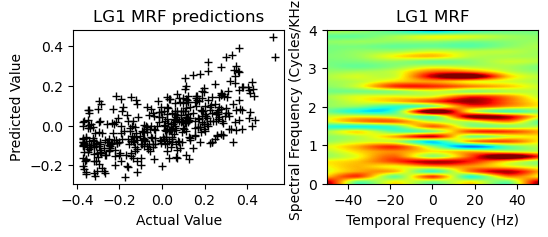

In [230]:
# Plot predictions and MRF for first LaGuerre

plt.figure(figsize=(6,2), dpi = 100)

plt.subplot(1,2,1)
plt.plot(respLG[:,0], respLGPred[:,0], 'k+')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('LG1 MRF predictions')

plt.subplot(1,2,2)
MRFPlot = MRF_LG[0,:].reshape(len(indwf), len(indwt))
maxabs = np.max((MRFPlot.max(), -MRFPlot.min()))
cmap = plt.get_cmap('jet')
ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
plt.imshow(MRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.title('LG1 MRF')


plt.ylim((0,4))
plt.xlim((-50, 50))
plt.clim((-maxabs*0.8, maxabs*0.8))

plt.savefig(os.path.join(figDir, 'LG1_MRF.eps'))




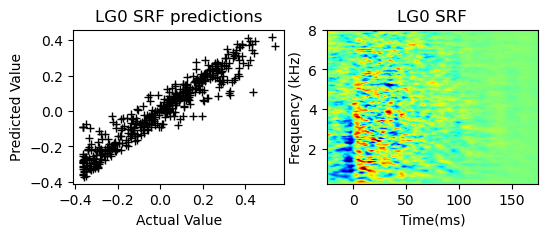

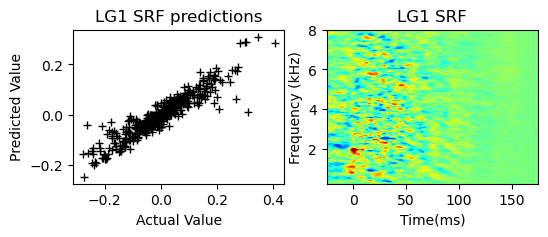

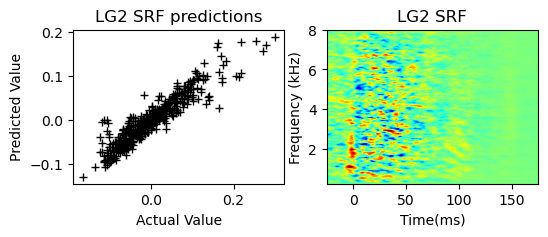

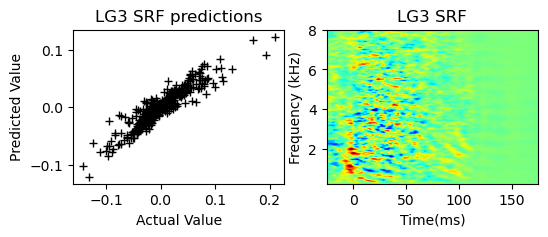

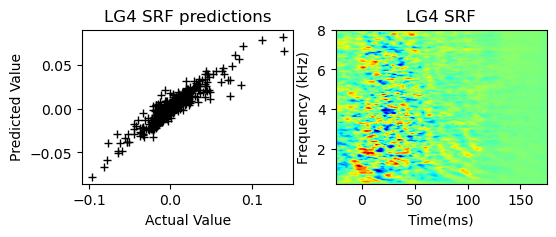

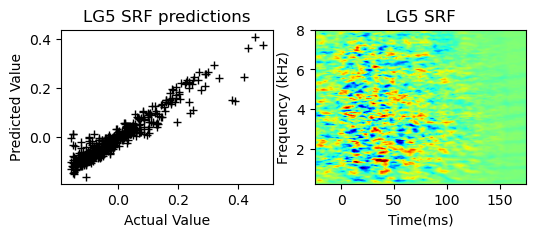

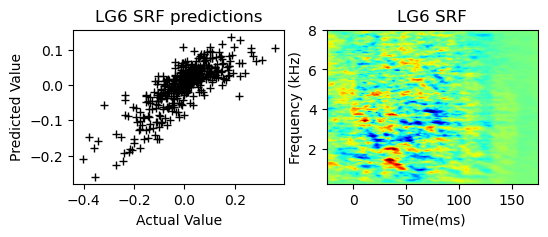

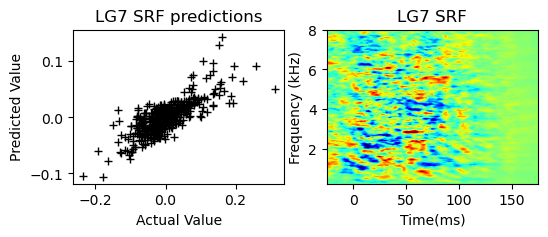

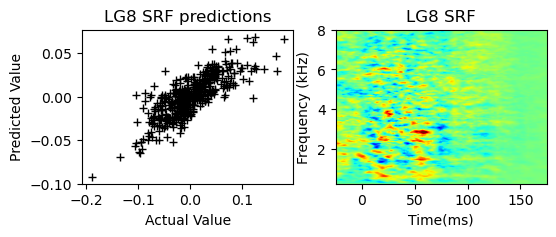

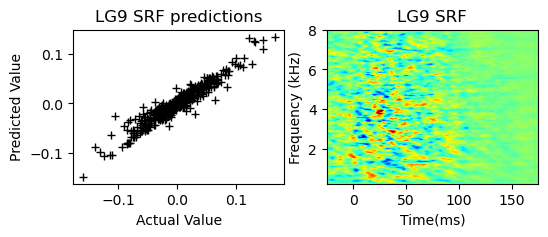

In [268]:

for iLG in range(10):
    plt.figure(figsize=(6,2), dpi = 100)

    plt.subplot(1,2,1)
    plt.plot(respLG[:,iLG], respLGPredSpect[:,iLG], 'k+')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('LG%d SRF predictions' % iLG)

    plt.subplot(1,2,2)
    SRFPlot = SRF_LG[iLG,:].reshape(stimSpect.shape[1], stimSpect.shape[2])
    maxabs = np.max((SRFPlot.max(), -SRFPlot.min()))
    cmap = plt.get_cmap('jet')
    ex = (-segmentBuffer, respChunkLen-segmentBuffer , 0.25, 8)
    plt.imshow(SRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time(ms)')
    plt.title('LG%d SRF'%iLG)

    plt.clim((-maxabs*0.8, maxabs*0.8))

    plt.savefig(os.path.join(figDir, 'LG%d_SRF.eps'%iLG))

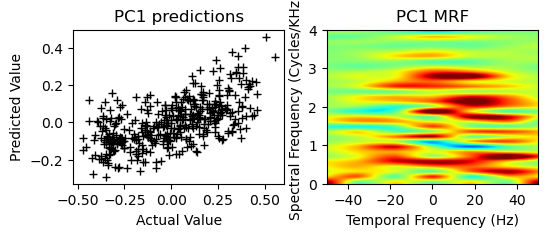

In [232]:
# Plot predictions and MRF for first PC

plt.figure(figsize=(6,2), dpi = 100)

plt.subplot(1,2,1)
plt.plot(respPC[:,0], respPCPred[:,0], 'k+')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('PC1 predictions')

plt.subplot(1,2,2)
MRFPlot = MRF[0,:].reshape(len(indwf), len(indwt))
maxabs = np.max((MRFPlot.max(), -MRFPlot.min()))
cmap = plt.get_cmap('jet')
ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
plt.imshow(MRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.title('PC1 MRF')


plt.ylim((0,4))
plt.xlim((-50, 50))
plt.clim((-maxabs*0.8, maxabs*0.8))

plt.savefig(os.path.join(figDir, 'PC1_MRF.eps'))

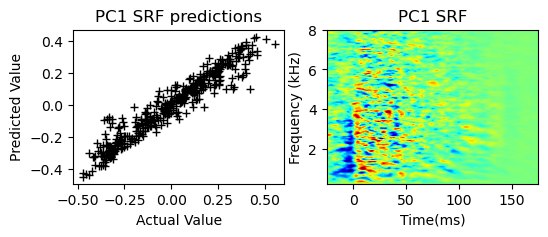

In [233]:
plt.figure(figsize=(6,2), dpi = 100)

plt.subplot(1,2,1)
plt.plot(respPC[:,0], respPCPredSpect[:,0], 'k+')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('PC1 SRF predictions')

plt.subplot(1,2,2)
SRFPlot = SRF[0,:].reshape(stimSpect.shape[1], stimSpect.shape[2])
maxabs = np.max((SRFPlot.max(), -SRFPlot.min()))
cmap = plt.get_cmap('jet')
ex = (-segmentBuffer, respChunkLen-segmentBuffer , 0.25, 8)
plt.imshow(SRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time(ms)')
plt.title('PC1 SRF')

plt.clim((-maxabs*0.8, maxabs*0.8))

plt.savefig(os.path.join(figDir, 'PC1_SRF.eps'))

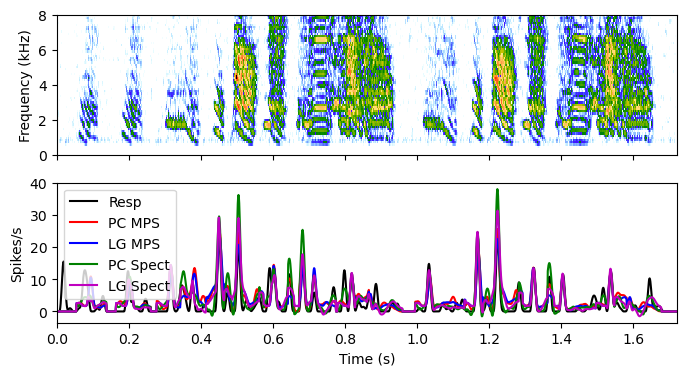

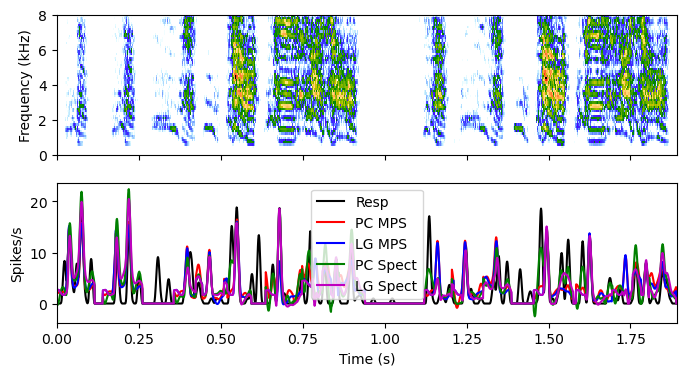

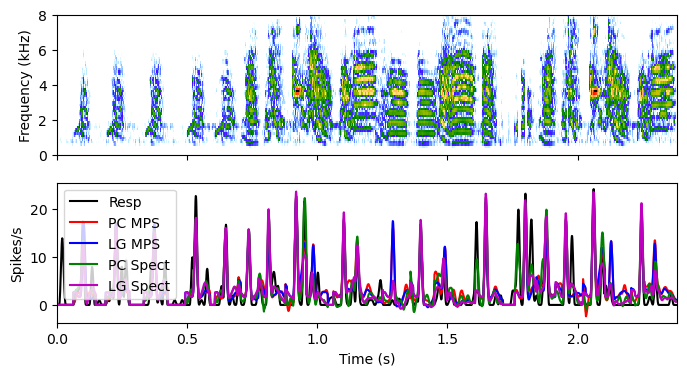

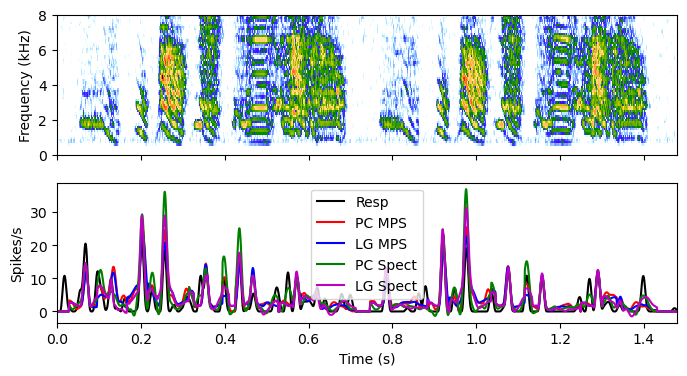

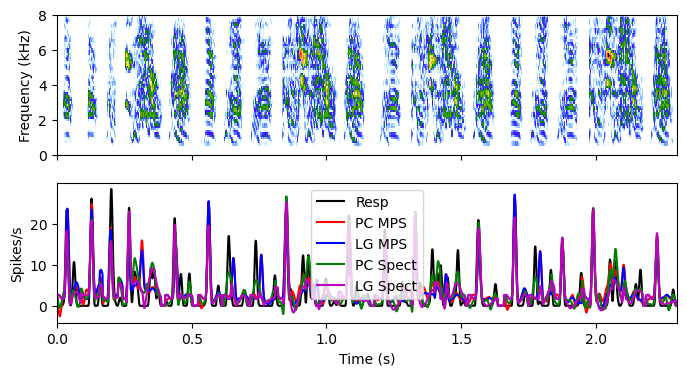

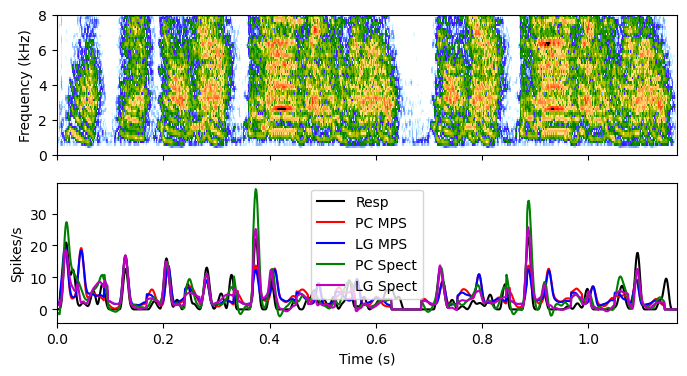

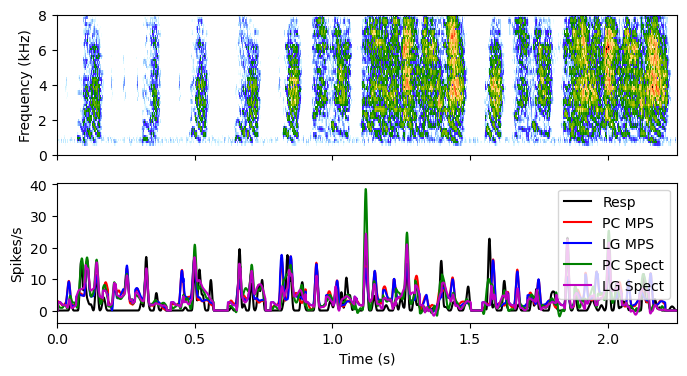

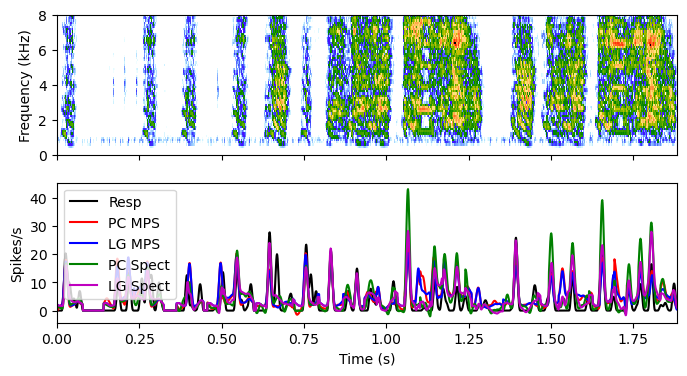

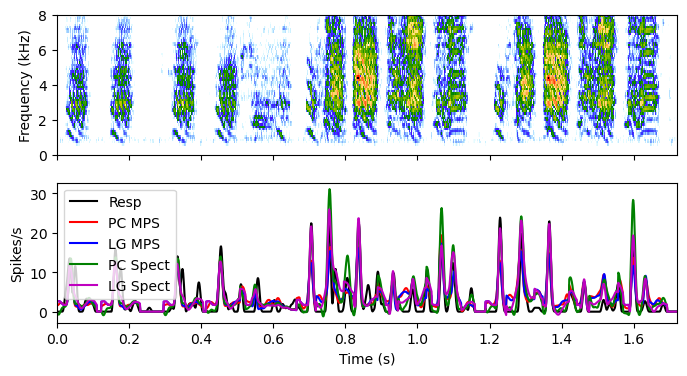

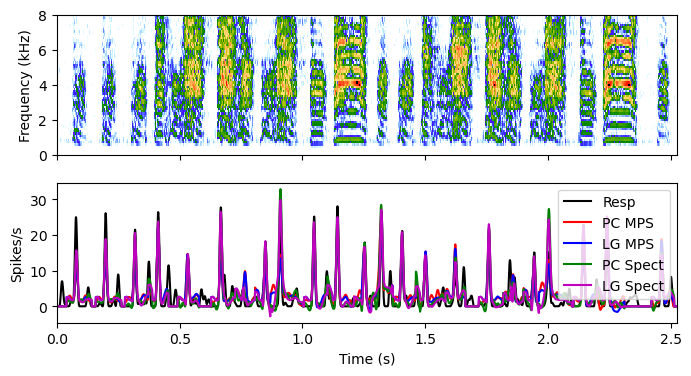

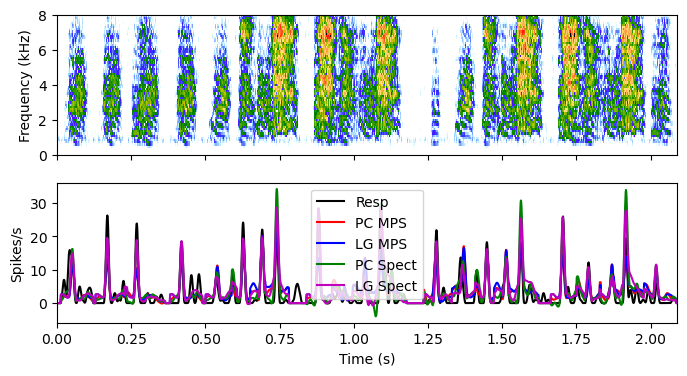

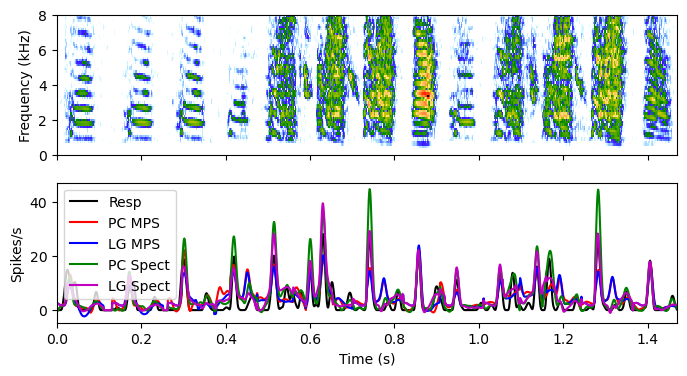

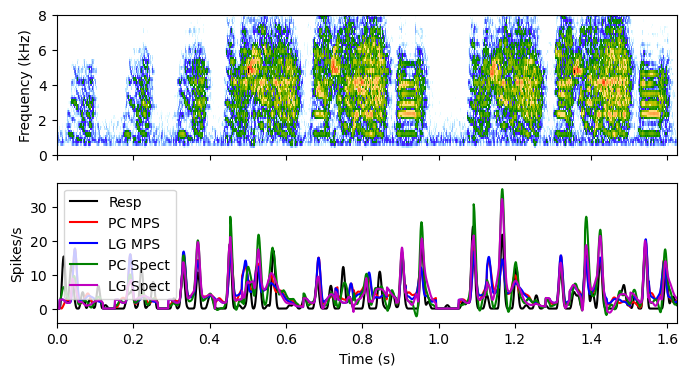

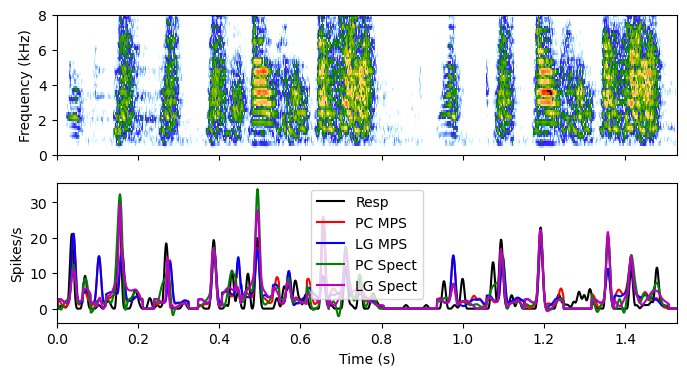

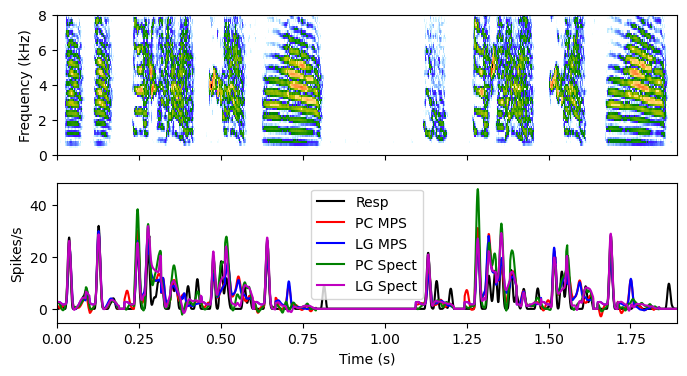

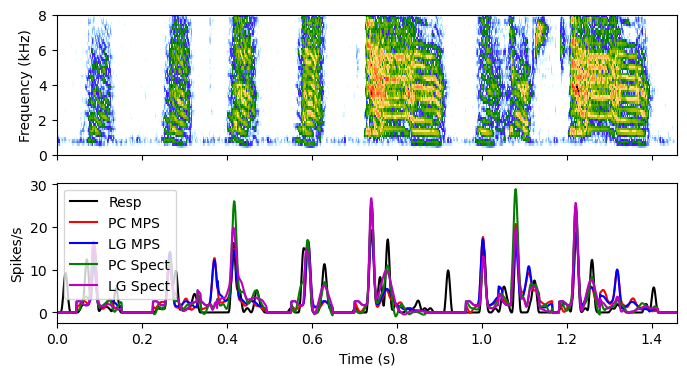

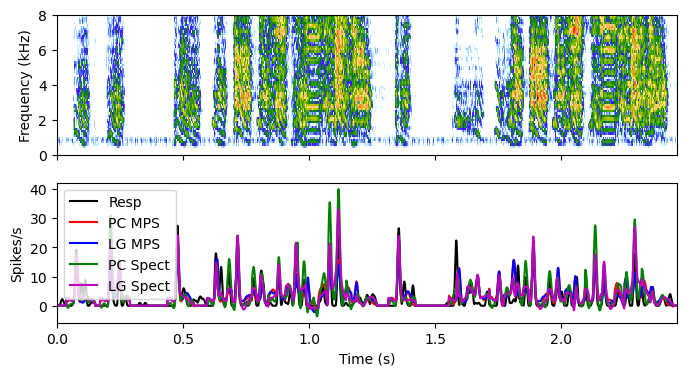

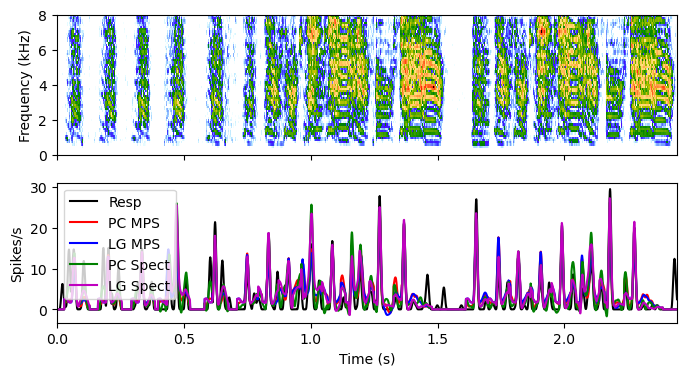

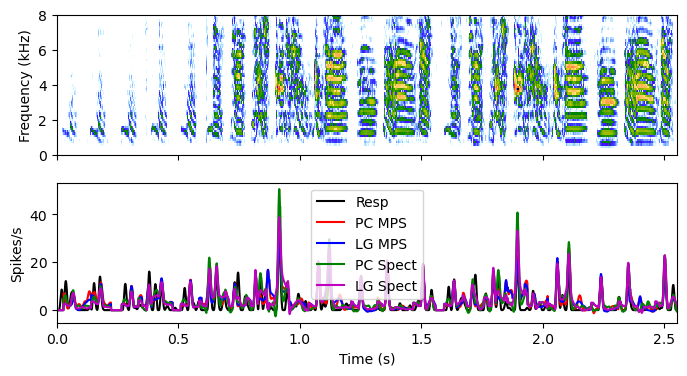

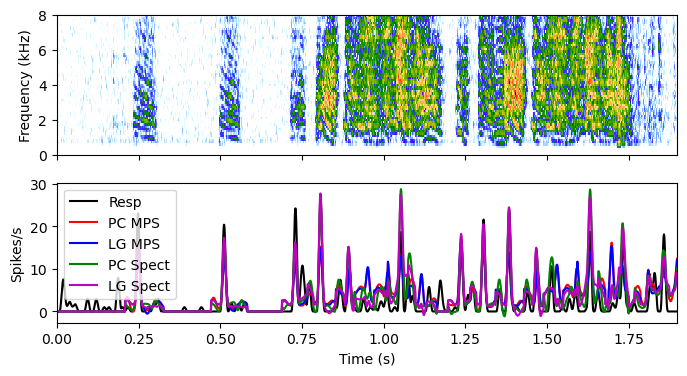

In [234]:
# Generate, Store and Plot the Predictions by rejoining the predictions for each segment.
# Note that we are only using the positive R2

# Making variables for the concatenated predictions
concatPredRespPCMPS = np.array([])
concatPredRespPCSpect = np.array([])
concatPredRespLGMPS = np.array([])
concatPredRespLGSpect = np.array([])
concatResp = np.array([])

# We are calculating these for a coherence estimation but this is not happening yet.
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])
pairCountTrials = np.zeros(pairCount)

nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram


# Color map for spectrograms
spec_colormap()   # defined in sound.py

for iSet in range(pairCount) :

    # Get the stimulus (spectrogram) and the response
    ds = srData['datasets'][iSet]
    resp = ds['resp']['psth']
    tfrep = ds['stim']['tfrep']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    
    # Generate the prediction
    respPredictionPCMPS = np.zeros(respSmoothed.shape)
    respPredictionLGMPS = np.zeros(respSmoothed.shape)
    respPredictionPCSpect = np.zeros(respSmoothed.shape)
    respPredictionLGSpect = np.zeros(respSmoothed.shape)

    for iChunk in range(nChunk):
        if (chunkID['set'][iChunk] == iSet):
            
            # Start the prediction with the mean PC
            respPredictionPCMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionPCMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            respPredictionPCSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionPCSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]

            # or the mean response
            respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += meanResp[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += meanResp[chunkID['respIndStart'][iChunk]:segmentBuffer]
            respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += meanResp[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += meanResp[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
            # Now add contribution of each PC fit if R2 above threshold
            for iPC in range(nPC):
                if (r2PC[iPC] > 0.01) :
                    respPredictionPCMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                    respPredictionPCMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]
                
                if (r2PCSpect[iPC] > 0.01) :
                    respPredictionPCSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPredSpect[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                    respPredictionPCSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPredSpect[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]

            # Same for the Laguerre polynomials
            for iLG in range(nLG):
                if (r2LG[iLG] > 0.01) :
                    if iLG < order:
                        respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPred[iChunk, iLG]*onsetLG[iLG,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPred[iChunk, iLG]*onsetLG[iLG,chunkID['respIndStart'][iChunk]:segmentBuffer]
                    else:
                        respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPred[iChunk, iLG]*sustainedLG[iLG-order,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPred[iChunk, iLG]*sustainedLG[iLG-order,chunkID['respIndStart'][iChunk]:segmentBuffer]
                if (r2LGSpect[iLG] > 0.01) :
                    if iLG < order:
                        respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPredSpect[iChunk, iLG]*onsetLG[iLG,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPredSpect[iChunk, iLG]*onsetLG[iLG,chunkID['respIndStart'][iChunk]:segmentBuffer]
                    else:
                        respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPredSpect[iChunk, iLG]*sustainedLG[iLG-order,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPredSpect[iChunk, iLG]*sustainedLG[iLG-order,chunkID['respIndStart'][iChunk]:segmentBuffer]





    
    # Store the prediction and the actual response in a single vector to calculate predition quality
    concatPredRespPCMPS = np.concatenate((concatPredRespPCMPS, respPredictionPCMPS))
    concatPredRespPCSpect = np.concatenate((concatPredRespPCSpect, respPredictionPCSpect))
    concatPredRespLGMPS = np.concatenate((concatPredRespLGMPS, respPredictionLGMPS))
    concatPredRespLGSpect = np.concatenate((concatPredRespLGSpect, respPredictionLGSpect))

    concatResp = np.concatenate((concatResp, respSmoothed))

    # Get raw spike data divided into two for coherency calculations
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeIndicies'], resp.shape[0])
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    numTrials = len(ds['resp']['rawSpikeTimes'])  # One needs to check that all numTrials are equal
    pairCountTrials[iSet] = numTrials
    
    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

    # The spectrogram
    soundSpect = np.copy(tfrep['spec'])
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # ax1.set_xlabel('Time (s)')

    # The prediction
    fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
    ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
    ax2.plot(tfrep['t'], respPredictionPCMPS*fac, 'r', label='PC MPS')
    ax2.plot(tfrep['t'], respPredictionLGMPS*fac, 'b', label='LG MPS')
    ax2.plot(tfrep['t'], respPredictionPCSpect*fac, 'g', label='PC Spect')
    ax2.plot(tfrep['t'], respPredictionLGSpect*fac, 'm', label='LG Spect')
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    plt.legend()

    # This code is to save figures for papers, etc including the modulation power spectrum of different chunks
    if iSet  == -1 :
        plt.savefig(os.path.join(figDir, 'stimRespMRFPred%d.eps' % (iSet)))
        for iChunk in range(nChunk):
            if (chunkID['set'][iChunk] == iSet):
                plt.figure(figsize=(2,2), dpi = 100)
                MPSPlot = stimMPSFeat[iChunk,:].reshape(len(indwf), len(indwt))
                maxabs = np.max((MPSPlot.max(), -MPSPlot.min()))
                cmap = plt.get_cmap('jet')
                ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
                plt.imshow(MPSPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
                
                plt.ylim((0,4))
                plt.xlim((-50, 50))
                plt.clim((-maxabs*0.8, maxabs*0.8))
                plt.axis('off')
                plt.savefig(os.path.join(figDir, 'stimMPSChunk%d_%d.eps' % (iSet, iChunk)))

 
            



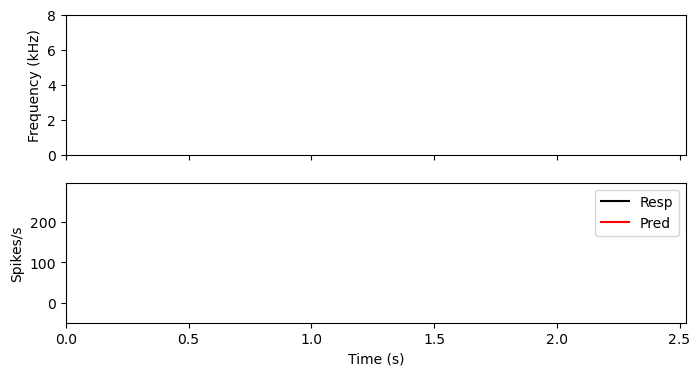

In [41]:
# Add an animation
nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram
iSet = 9      # The one to plot/animate

# Color map for spectrograms
spec_colormap()   # defined in sound.py

# Get the stimulus (spectrogram) and the response
ds = srData['datasets'][iSet]
resp = ds['resp']['psth']
tfrep = ds['stim']['tfrep']
numTrials = len(ds['resp']['rawSpikeTimes']) 
respSmoothed = np.convolve(resp, wHann, mode='same')
    
# Generate the prediction
respPrediction = np.zeros(respSmoothed.shape)
for iChunk in range(nChunk):
    if (chunkID['set'][iChunk] == iSet):       
        # Start the prediction with the mean PC
        respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
        # Now add contribution of each PC fit if R2 above threshold
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]


allArtists = [] 
# Plot the spectrogram and the prediction
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

# The spectrogram
soundSpect = np.copy(tfrep['spec'])
maxB = soundSpect.max()
minB = maxB-DBNOISE
soundSpect[soundSpect < minB] = minB
minSpect = soundSpect.min()
cmap = plt.get_cmap('SpectroColorMap')
    
imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

# The response
fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
line2, = ax2.plot([], [], 'r', label='Pred')

ax2.set_ylabel('Spikes/s')
ax2.set_xlabel('Time (s)')
ax2.legend()

# Initialize
allArtists.append([imag1, line1])

# Make new artist objects
for iChunk in range(nChunk):

    if (chunkID['set'][iChunk] == iSet):  
        istart =  chunkID['indStart'][iChunk]
        izero = chunkID['indZero'][iChunk]
        iend = chunkID['indEnd'][iChunk]

        # First replot the spectrogram with a box
        #imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                # aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
        # Add a black rectangle 
        width = tfrep['t'][iend] - tfrep['t'][istart] 
        height = (tfrep['f'][-1] - tfrep['f'][0])*1e-3
        imag2 = Rectangle((tfrep['t'][istart], tfrep['f'][0]*1e-3), width, height, color = 'k', linewidth = 2, fill = False ) 
        ax1.add_patch(imag2)
        allArtists.append([imag1, imag2, line1, line2])
        

        # Start the prediction with the mean PC
        predPC0 = np.zeros(chunkID['respIndEnd'][iChunk])
        predPC0[segmentBuffer:chunkID['respIndEnd'][iChunk]] = pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer] = pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
        line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'b', label='PC0')
        allArtists.append([imag1, imag2, line1, line2, line3])
            
        # Now add contribution of each PC fit if R2 above threshold
        predPCX = np.zeros(chunkID['respIndEnd'][iChunk])
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                predPCX[segmentBuffer:chunkID['respIndEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer]  += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]
        line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'g', label='PCX')
        allArtists.append([imag1, imag2, line1, line2, line4])


        # Now erase previous partial responses and draw new reponse
        # line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'w', label='PC0')
        # line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'w', label='PCX')
        line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
        line2, = ax2.plot(tfrep['t'][0:iend], respPrediction[0:iend]*fac, 'r', label='Pred')
        # allArtists.append([line3, line4, line1, line2])
        allArtists.append([imag1, imag2, line1, line2])


# Animate
anim = animation.ArtistAnimation(f, allArtists, interval = 500, blit=True)

 


In [42]:
# Create and save the animation
anim.save(os.path.join(figDir, 'smfrAnimation.mp4'), fps=2, dpi=300)

Compute the goodness of fit of the prediction. 
Here we are just calculating the correlation coefficient but this code can be changed to the coherency as well.

In [235]:
# Pearson r betwen prediction and response
concatPredResp = [concatPredRespPCMPS, concatPredRespLGMPS, concatPredRespPCSpect, concatPredRespLGSpect]
predRespType = ['MPS PC', 'MPS LG', 'Spect PC', 'Spect LG']

for predResp, type in zip(concatPredResp, predRespType):
    r = np.corrcoef(predResp, concatResp)[0,1]
    # Pearson r betwwen two half of psth to get estimate of Explainable Variance (EV)
    r12 = np.corrcoef(np.convolve(concatPsthHalf1, wHann, mode='same'), np.convolve(concatPsthHalf2, wHann, mode='same'))[0,1]

    # The following code is only exactkt correct in pairCountTrials are equal for all stim-resp pairs but good aprox otherwise

    SNRAll = 2*r12/(1-r12)  
    R2Ceil = SNRAll/(1+SNRAll)   # This is the ceiling value of R2 

    print('%s: r= %.3f, R2 = %.3f R2Ceil = %.3f R2Norm = %.3f' % (type, r, r*r, R2Ceil, r*r/R2Ceil))


MPS PC: r= 0.684, R2 = 0.467 R2Ceil = 0.972 R2Norm = 0.481
MPS LG: r= 0.680, R2 = 0.462 R2Ceil = 0.972 R2Norm = 0.476
Spect PC: r= 0.838, R2 = 0.702 R2Ceil = 0.972 R2Norm = 0.723
Spect LG: r= 0.819, R2 = 0.670 R2Ceil = 0.972 R2Norm = 0.690
